In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import glob
import os
from os import *
import re
import imutils
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import collections
import random
import shutil
import scipy.fftpack as sfft


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [59]:
#/home/jovyan/DATA_MASTER_PROJECT/TRY_GODDNESS_OF_MODEL/full_train/*.tiff'

image_list = []
    

for filename in sorted(glob.glob('/home/jovyan/DATA_MASTER_PROJECT/IMG_A549_high_con/full_size_HRH/*.tiff'), key=natural_keys): 
    
    im=cv2.imread(filename,1)
    imarray = np.array(im)
    if np.count_nonzero(imarray == 255) < 1000:
        image_list.append(imarray)

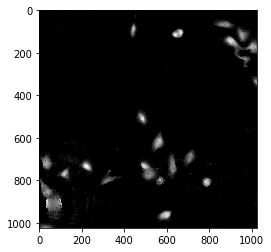

In [64]:
plt.imshow(image_list[2])


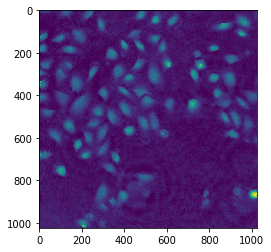

In [66]:
img = cv2.imread('/home/jovyan/bright_img.png',0)
plt.imshow(img)


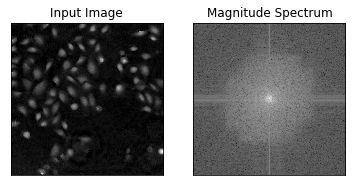

In [67]:
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [68]:
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

In [69]:
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)  # center

# Concentric BPF mask,with are between the two cerciles as one's, rest all zero's.
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

# Band Pass Filter

In [70]:
mask = np.zeros((rows, cols, 2), np.uint8)
r_out = 90
r_in = 5
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]

mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                           ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
mask[mask_area] = 1

# Low Pass filter


In [ ]:
mask = np.zeros((rows, cols, 2), np.uint8)
r = 100
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


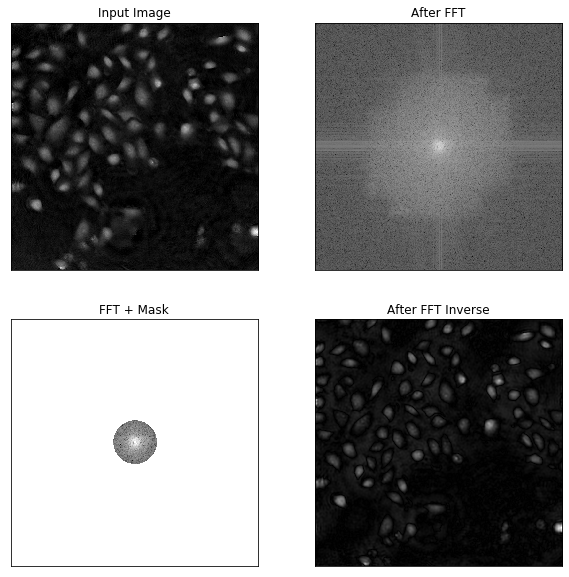

In [71]:
# apply mask and inverse DFT
fshift = dft_shift * mask

fshift_mask_mag = 2000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

fig = plt.figure(figsize=(10, 10))

ax= fig.add_subplot(2, 2, 1), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('After FFT'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(fshift_mask_mag, cmap='gray')
plt.title('FFT + Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(img_back, cmap='gray')
plt.title('After FFT Inverse'), plt.xticks([]), plt.yticks([])
plt.show()



In [72]:
filtered_img = np.abs(img_back)
filtered_img -= filtered_img.min()
filtered_img = filtered_img*255 / filtered_img.max()
filtered_img = filtered_img.astype(np.uint8)

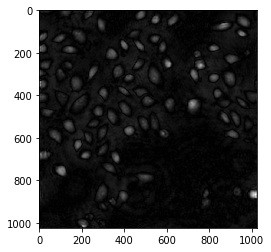

In [73]:
img1 = cv2.cvtColor(filtered_img, cv2.COLOR_GRAY2RGB)
plt.imshow(img1)

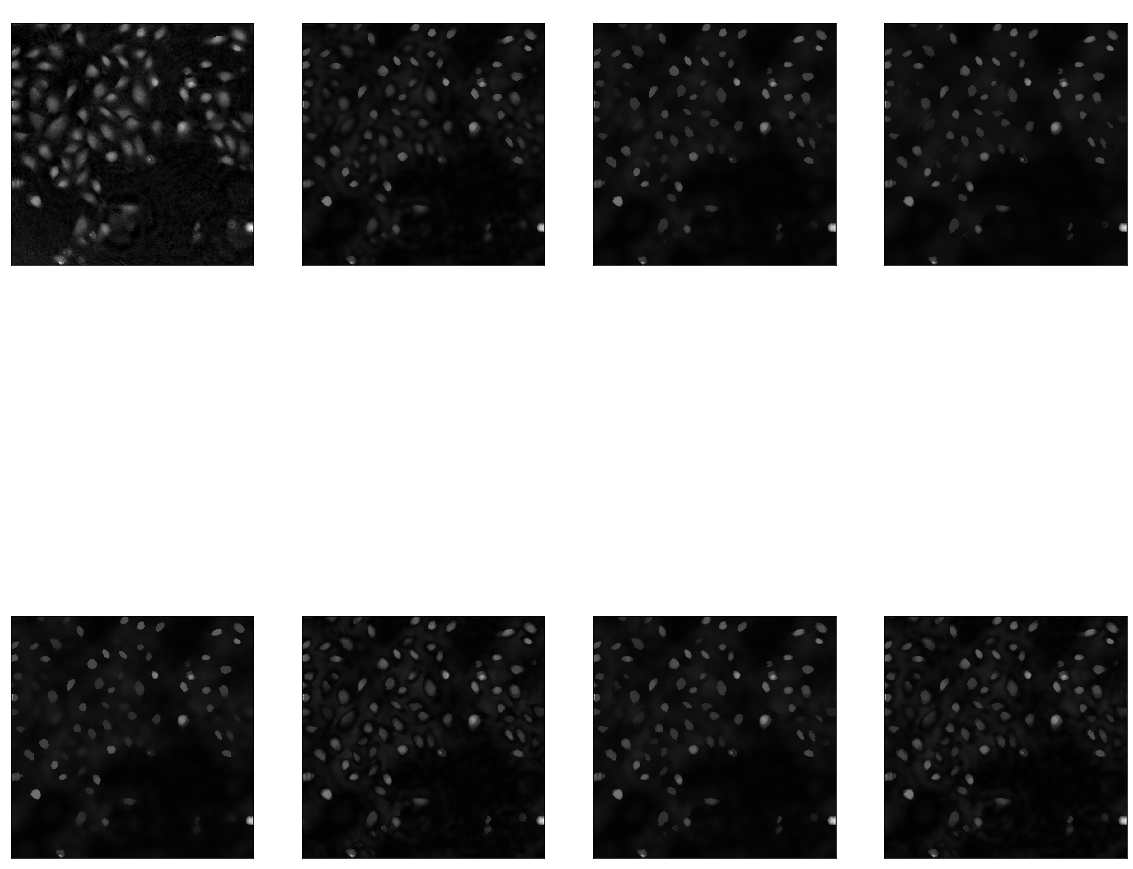

In [74]:
shifted1 = cv2.pyrMeanShiftFiltering(img1, 10, 50)
shifted2 = cv2.pyrMeanShiftFiltering(img1, 20, 40)
shifted3 = cv2.pyrMeanShiftFiltering(img1, 30, 30)
shifted4 = cv2.pyrMeanShiftFiltering(img1, 20, 50)
shifted5 = cv2.pyrMeanShiftFiltering(img1, 10, 20)
shifted6 = cv2.pyrMeanShiftFiltering(img1, 20, 30)
shifted7 = cv2.pyrMeanShiftFiltering(img1, 10, 30)




titles = ['Original Image','1','2','3','4','5','6','7']
images = [img, shifted1,shifted2,shifted3,shifted4,shifted5,shifted6,shifted7]

fig = plt.figure(figsize=(20, 20))


for i in range(8):
    ax = fig.add_subplot(2,4,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], color='white')
    plt.xticks([]),plt.yticks([])
plt.show()

In [75]:
gray = cv2.cvtColor(shifted6,cv2.COLOR_BGR2GRAY)

In [76]:
thresh1 = cv2.threshold(filtered_img,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

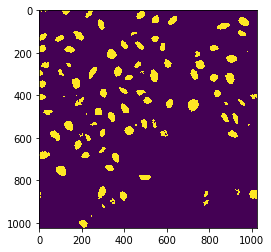

In [77]:
plt.imshow(thresh1)

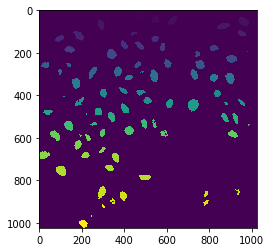

In [78]:
D = ndimage.distance_transform_edt(thresh1)
localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh1)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh1)

plt.imshow(labels)



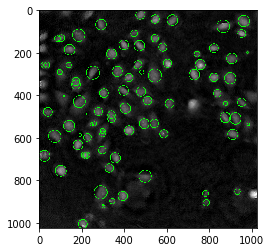

In [79]:
ar = []
cx = []
cy = []
img2 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
for label in np.unique(labels):
    if label == 0:
        continue
        
    
    mask = np.zeros(gray.shape, dtype='uint8')
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    
    
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(c)
    area = cv2.contourArea(c)
    if area < 2000:
        cx.append(int(x))
        cy.append(int(y))
        ar.append(area)

        #cv2.drawContours(img2, [c], -1,(0, 255, 0), 2)
        cv2.circle(img2, (int(x), int(y)), int(r), (0, 255, 0), 2)

plt.imshow(img2)

In [ ]:
sorted(ar)